In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy
import cartopy.crs as ccrs
import atlite
import rasterio
import pypsa
import os
import yaml
import re
from matplotlib.lines import Line2D

with open('../../pypsa-earth/config.SEA_base.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [20]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
country_longname = {
    "MM": "Myanmar",
    "TH": "Thailand",
    "MY": "Malaysia",
    "LA": "Laos",
    "SG": "Singapore",
    "KH": "Cambodia",
    "VN": "Vietnam",
    "BN": "Brunei",
    "PH": "Philippines",
    "ID": "Indonesia",
    "Peninsular/MY": "Malay Peninsular (M)",
    "Sumatra/ID": "Sumatra (I)",
    "Java-Bali/ID": "Java-Bali (I)",
    "Sarawak/MY":  "Sarawak (M)",
    "Kalimantan/ID": "Kalimantan (I)",
    "Sabah/MY": "Sabah (M)",
    "Nusa-Tenggara/ID": "Nusa-Tenggara (I)",
    "Sulawesi/ID": "Sulawesi (I)",
    "Maluku/ID": "Maluku (I)",
    "Papua/ID": "West Papua (I)"
    }

country_prefered_order = ['Myanmar', 'Thailand', 'Sumatra (I)', 'Malay Peninsular (M)','Singapore', 'Laos', 'Cambodia', 'Vietnam', 'Java-Bali (I)',
                          'Kalimantan (I)', 'Sarawak (M)', 'Brunei', 'Sabah (M)','Nusa-Tenggara (I)', 'Sulawesi (I)', 'Philippines', 'Maluku (I)',
                          'West Papua (I)']

preferred_order = pd.Index(
    [
        "transmission lines",
        "hydroelectricity",
        "hydro reservoir",
        "run of river",
        "pumped hydro storage",
        "onshore wind",
        "offshore wind ac",
        "offshore wind dc",
        "solar PV",
        "solar thermal",
        "OCGT",
        "hydrogen storage",
        "battery storage",
    ]
)

def add_and_rename_countries(df):
    for i in list(country_longname.keys() - set(df.index)):
        df.loc[i] = pd.Series().fillna(0)

    # convert abbreviation into nice long names
    df["Countries"] = [country_longname[c] for c in df.index]
    df = df.set_index("Countries")

    return df

def rename_techs(label):
    if "H2" in label:
        label = "hydrogen storage"
    elif label == "solar":
        label = "solar PV"
    elif label == "offwind-ac":
        label = "offshore wind ac"
    elif label == "offwind-dc":
        label = "offshore wind dc"
    elif label == "onwind":
        label = "onshore wind"
    elif label == "ror":
        label = "hydroelectricity"
    elif label == "hydro":
        label = "hydroelectricity"
    elif label == "PHS":
        label = "hydroelectricity"
    elif "battery" in label:
        label = "battery storage"

    return label

In [22]:
def calculate_LCOE(n, scenario_PyPSA, dec_name):
    fossil_fuel = ["nuclear", "oil", "OCGT", "CCGT", "coal", "coal-SubC", "coal-SC", "coal-USC", "coal-CFB", "lignite", "geothermal", "biomass"]
    renewable = [ "offwind-dc", "offwind-ac","onwind", "solar"]
    
    df_gen = pd.DataFrame(index=n.generators.index)
    df_gen["carrier"] = n.generators.carrier
    df_gen["country"] = n.generators.bus.map(n.buses.country)
    df_gen["p_max"] = n.generators.p_nom_max
    df_gen["p_max_pu"] = n.snapshot_weightings.generators @ n.generators_t.p_max_pu
    df_gen["p_max_pu"] = df_gen["p_max_pu"].fillna(0)
    df_gen["p_max_pu"] = [8760 if df_gen.loc[i,"carrier"] in fossil_fuel else df_gen.loc[i,"p_max_pu"] for i in df_gen.index]
    df_gen["e_max"] = df_gen["p_max"] * df_gen["p_max_pu"]
    
    df_gen["lcoe_max"] = n.generators.capital_cost/(df_gen["p_max_pu"]) + n.generators.marginal_cost
    df_gen["lcoe_actual"] = n.generators.capital_cost/(n.snapshot_weightings.generators @ n.generators_t.p/n.generators.p_nom_opt) + n.generators.marginal_cost
    
    df_gen["lcoe_max_e"] = df_gen["lcoe_max"] * df_gen["e_max"]
    df_gen["lcoe_actual_e"] = df_gen["lcoe_actual"] * df_gen["e_max"]

    df_LCOE = pd.DataFrame(columns=renewable + [f"{r}_cap" for r in renewable], index=n.buses.country.unique())
    #refactor = 1e7
    
    for country in df_LCOE.index:
        for carrier in renewable:
            df_LCOE.loc[country,f"{carrier}_cap"] = df_gen.query("country == @country & carrier == @carrier").e_max.sum() #/ refactor
            df_LCOE.loc[country,carrier] = df_gen.query("country == @country & carrier == @carrier").lcoe_max_e.sum()/df_gen.query("country == @country & carrier == @carrier").e_max.sum()
    
    df_LCOE = df_LCOE.fillna(1e9)
    df_LCOE = add_and_rename_countries(df_LCOE)
    
    new_index_order = [c for c in country_prefered_order if c in df_LCOE.index]
    df_LCOE = df_LCOE.loc[new_index_order]

    #

    df_LCOE["index"] = range(18)

    return df_LCOE

In [23]:
scenarios = ["SEA_AIMS_", "SEA_ERA5_2013_AIMS_", "SEA_ERA5_2011_AIMS_"]
folder_name = "pypsa-earth"
network_name = "elec_s_200_ec_lcopt_Co2L0.050092-3H"
dec_name = "DEC"

year = 2050

fn = {scenario:pypsa.Network(f"../../{folder_name}/results/{scenario}{year}/networks/{network_name}.nc") for scenario in scenarios}

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


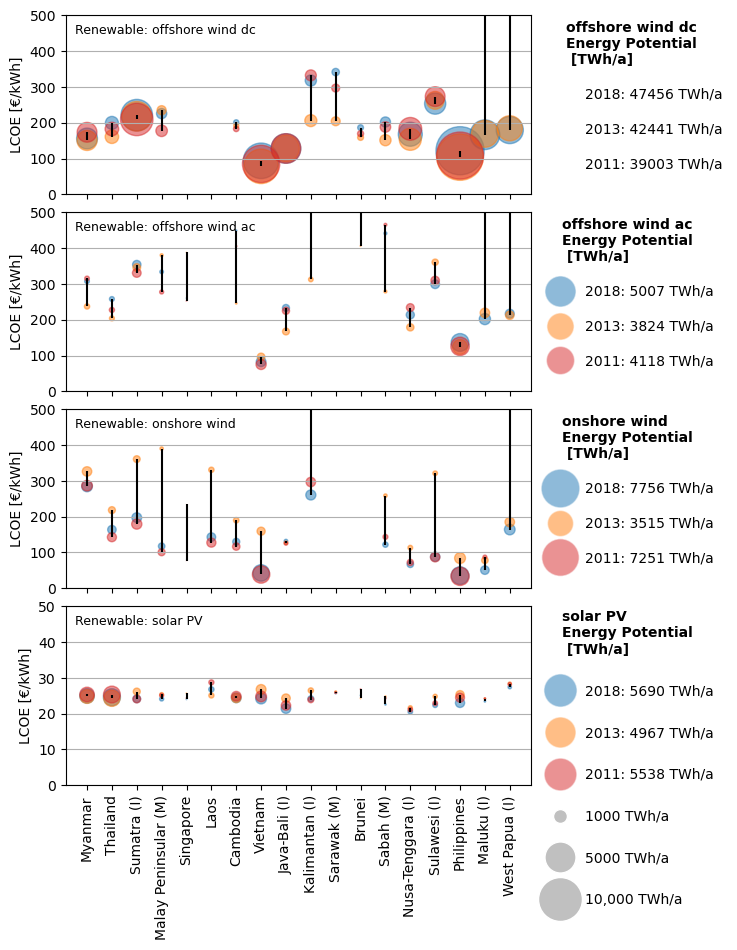

In [52]:
renewable = [ "offwind-dc", "offwind-ac","onwind", "solar"]

color_scenario = {"SEA_AIMS_": 'tab:blue', 
                "SEA_ERA5_2013_AIMS_": 'tab:orange', 
                "SEA_ERA5_2011_AIMS_": 'tab:red',
                }

nice_scenario_name = {"SEA_AIMS_": '2018', 
                    "SEA_ERA5_2013_AIMS_": '2013', 
                    "SEA_ERA5_2011_AIMS_": '2011',
                    }

LCOE_result = {}

for scenario in scenarios:
    LCOE_result[scenario] = calculate_LCOE(fn[scenario], scenario, dec_name)

fig, ax = plt.subplots(len(renewable), 1, figsize=(6,10))
#fig, ax = plt.subplots(len(renewable), 1, figsize=(6,16))
plt.subplots_adjust(wspace=0.15, hspace=0.10)
c_num = 0
refactor = 1e7

for r in renewable:
    for scenario in scenarios:
        df_all = LCOE_result[scenario]
        df_all.loc[:,f"{r}_cap"] = df_all.loc[:,f"{r}_cap"]/refactor
        
        if r == "solar":
            df_all.loc[:,r] = df_all.loc[:,r] * 10
            
        df_all.plot.scatter(x="index", y=r, s=f"{r}_cap",ax=ax[c_num], color=color_scenario[scenario], alpha= 0.5,  linewidth = 1)
        #df_all.loc[:,f"{r}_cap"] = df_all.loc[:,f"{r}_cap"] * refactor

    df = pd.DataFrame(data={scenario:LCOE_result[scenario][r] for scenario in scenarios })
    if r == "solar":
        df
    
    for c in df.index:
        ax[c_num].vlines(x=c, ymin=df.loc[c].min(), ymax=df.loc[c].max(), color="black")

    plt.xticks(range(18), df_all.index, rotation=90)
    
    ax[c_num].set_ylim([0, 500])
    ax[c_num].grid(axis="y")
    #ax[c_num].grid(axis="x")
    ax[c_num].set_xlabel("")
    ax[c_num].set_ylabel("LCOE [€/kWh]")

    if r == "solar":
        ax[c_num].set_yticklabels([0,10,20,30,40,50])
    else:
        ax[c_num].set_xticklabels([])

    #text_list = [nice_scenario_name[scenario] + " : " + str(round(LCOE_result[scenario][f"{r}_cap"].sum() * refactor * MWh_to_TWh)) + " TWh" for scenario in scenarios]
    #text = rename_techs(r) + "\nenergy potential in year :\n" + '\n'.join(text_list)
    #ax[c_num].text(1.22, 0.5,text, transform=ax[c_num].transAxes,
    #            verticalalignment='center', horizontalalignment='center')

    ax[c_num].set_title(f'Renewable: {rename_techs(r)}', 
              loc='left', 
              x=0.02, 
              y=0.85,
              fontsize=9
             )
    
    MWh_to_TWh = 1/1e6
    labelspacing=1.5
    factor = 0 if c_num == 0 else 1
    bbox_to_anchor = (1.005, 0.55)

    legend_elements = [Line2D([0], [0], marker='o', color='w', label=nice_scenario_name[scenario] + ": " + str(round(LCOE_result[scenario][f"{r}_cap"].sum() * refactor * MWh_to_TWh)) + " TWh/a",
                              markerfacecolor=color_scenario[scenario], alpha= 0.5, markersize=LCOE_result[scenario][f"{r}_cap"].sum() ** (1/2) * factor) for scenario in scenarios]
    if c_num == 3:
        bbox_to_anchor = (1.005, 0.15)
        legend_bus = {"sizes":[100, 500, 1000],
                      "labels":["1000 TWh/a", "5000 TWh/a", "10,000 TWh/a"]
                     }
        legend_bus["sizes_sqrt"] = list(map(lambda x:x ** (1/2), legend_bus["sizes"]))
        
        legend_elements = legend_elements + [Line2D([0], [0], marker='o', color='w', label=legend_bus["labels"][i],
                                                    markerfacecolor="silver", markersize=legend_bus["sizes_sqrt"][i]) for i in range(len(legend_bus["sizes"]))]
        labelspacing=2
        
        
    legend2 = ax[c_num].legend(handles=legend_elements, loc="center left", bbox_to_anchor=bbox_to_anchor,
                        frameon=False, labelspacing=labelspacing, title=f"{rename_techs(r)}\nEnergy Potential \n [TWh/a]",
                        title_fontproperties={'weight':'bold'})

    c_num += 1

wind_2018 = LCOE_result["SEA_AIMS_"][f"{r}_cap"].sum()# * refactor * MWh_to_TWh

plt.savefig(f'../Figures/LCOE_different_weather_alt.svg',bbox_inches='tight')

## Energy Distribution Validation

In [10]:
def energy_distribution(infn_energy, scenario_PyPSA, dec_name, add_country_name = False):
    fig, (ax) = plt.subplots(figsize=(8, 3))
    df_all = pd.DataFrame()
    
    df_all = pd.DataFrame()
    loads_df_all = pd.DataFrame()
    
    for country in countries:
        energy_df = pd.read_csv(infn_energy[country], index_col=list(range(2)), header=[1, 2, 3])
    
        energy_df.columns = [country]
    
        df = energy_df.groupby(energy_df.index.get_level_values(1)).sum()
    
        loads_df = - energy_df.groupby(energy_df.index.get_level_values(0)).sum().query("index == 'loads'")/ 1e6
    
        # If there is any unique carrier to remove
        if "B2B" in df.index:
            df = df.drop("B2B")
    
        # convert MWh to TWh
        df = df / 1e6
    
        df = df.groupby(df.index.map(rename_techs)).sum()
    
        if df_all.empty:
            df_all = df
        else:
            df_all = pd.concat([df_all,df],axis=1)
    
        if loads_df.empty:
            loads_df_all = loads_df
        else:
            loads_df_all = pd.concat([loads_df_all,loads_df],axis=1)
    
    new_index_energy = df_all.index.intersection(preferred_order).append(
        df.index.difference(preferred_order)
    )
    
    df_all = add_and_rename_countries(df_all.T).T
    
    #new_columns = df_all.columns.sort_values()
    new_columns = [c for c in country_prefered_order if c in df_all.columns]
    
    df_all.loc[new_index_energy, new_columns].T.plot(
        kind="bar",
        width = 0.9,
        ax=ax,
        stacked=True,
        color=[config["plotting"]["tech_colors"][i] for i in new_index_energy],
        rot=90,
        legend=False
    )
    
    loads_df_all = add_and_rename_countries(loads_df_all.T).T
    
    loads_df_all.loc[:, new_columns].T.plot(
        kind="bar",
        ax=ax,
        width = 0.9,
        edgecolor="black",
        linestyle = 'dashed',
        fill=False,
        rot=90,
        legend=False
    )
    
    ax.set_ylim([-200, 2000])
    ax.grid(axis="y")
    ax.set_xlabel("")
    ax.set_ylabel("TWh/a")

    if not add_country_name:
        ax.set_xticklabels([])
    ax.annotate('Regional\nLoad/a',
        xy=(4, loads_df_all["Singapore"]),  # theta, radius
        xytext=(4, loads_df_all["Singapore"]+750),    # fraction, fraction
        arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth = 5),
        horizontalalignment='center',
        verticalalignment='top',
        )

    ax.set_title(f'{scenario_PyPSA}{dec_name}_2050', 
                 loc='right', 
                 x=0.98, 
                 y=0.88,
                 fontsize=9
                )

    if not os.path.exists(f'../Figures/{scenario_PyPSA}{dec_name}'):
        os.mkdir(f'../Figures/{scenario_PyPSA}{dec_name}')

    plt.savefig(f'../Figures/{scenario_PyPSA}{dec_name}/{scenario_PyPSA}{dec_name}_energy_distribution.svg',bbox_inches='tight')

In [11]:
def add_energy_distribution_legend(n):
    fig, ax = plt.subplots(figsize=(0, 0))
    ax.axis('off')

    df_color = pd.DataFrame(data = {"color" : [n.carriers.loc[c,"color"] for c in n.generators.carrier.unique()]}, index = n.generators.carrier.unique())
    
    df_color = df_color.groupby(df_color.index.map(rename_techs)).sum()
    
    for i in ["hydrogen storage","battery storage"]:
        df_color.loc[i,"color"] = config["plotting"]["tech_colors"][i] 
    
    df_color.index.intersection(preferred_order).append(df_color.index.difference(preferred_order))
    
    df_color = df_color.drop(["coal","coal-CFB","coal-SC","coal-SubC","coal-USC","lignite","oil"])
    
    pypsa.plot.add_legend_patches(ax=ax, colors = df_color.color, labels = df_color.index,
                                 legend_kw = {'loc':"lower center",'bbox_to_anchor':(0.5, 1), 'frameon':False, 'ncol':4, 'title':"Energy Sources", 
                                              'title_fontproperties':{'weight':'bold'}})

    plt.savefig(f'../Figures/energy_distribution_legend.svg',bbox_inches='tight')


In [15]:
scenarios = ["SEA_IRENA_","SEA_ERA5_2013_IRENA_", "SEA_ERA5_2011_IRENA_"]
folder_name = "pypsa-earth"
network_name = "elec_s_200_ec_lcopt_Co2L0.050092-3H"
dec_name = "DEC"

year = 2050

fn = {scenario:pypsa.Network(f"../../{folder_name}/results/{scenario}{year}/networks/{network_name}.nc") for scenario in scenarios}

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


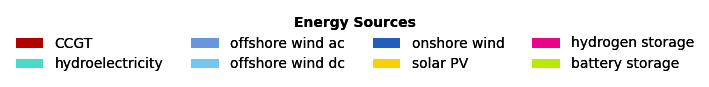

In [63]:
add_energy_distribution_legend(fn["SEA_IRENA_"])

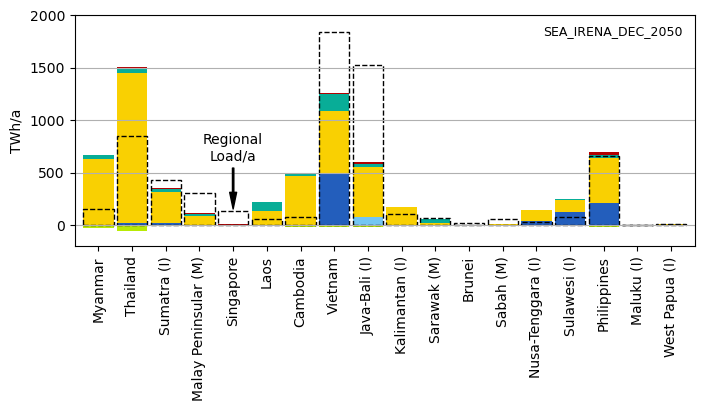

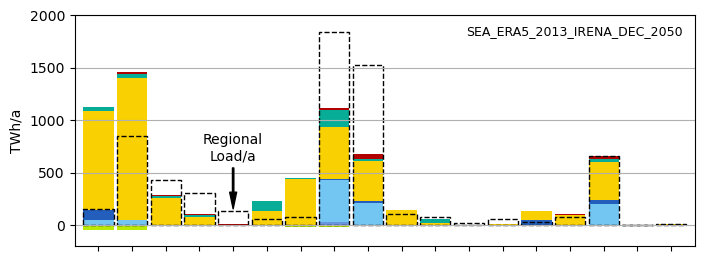

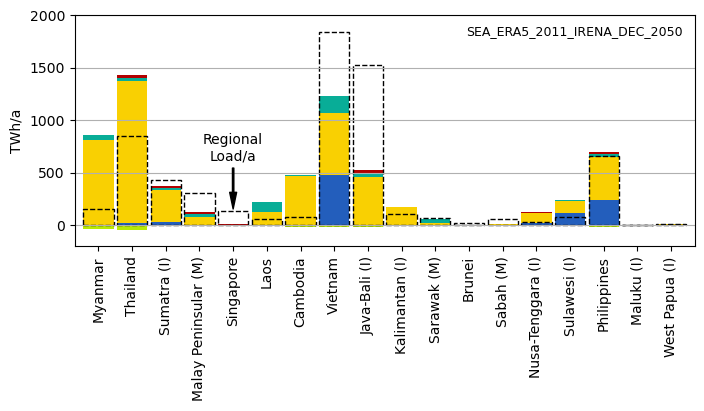

In [17]:
for scenario in scenarios:
    n = fn[scenario]
    countries = n.buses.country.unique()
    infn_energy = {country:f"../../{folder_name}/results/{scenario + str(year)}/summaries/{network_name}_{country}/energy.csv" for country in countries}
    add_country_name = True

    if scenario == "SEA_ERA5_2013_IRENA_":
        add_country_name = False
    
    energy_distribution(infn_energy, scenario, dec_name, add_country_name=add_country_name)